In [6]:
import matplotlib.pyplot as plt 
import numpy as np 
import torch

In [7]:
#---------------- vars 
x1 = 1
y1 = 1
a1 = 3 
b1 = 3 

x2 = 2 
y2 = 2
a2=  5
b2 = 5

# find the area for the box1 (x1,y1) (a1,b1)
area1 = (a1-x1)*(b1-y1)
 
# find the area for the box2 (x2,y2) (a2,b2)
area2 = (a2-x2)*(b2-y2)
 
# Now we need to find the intersec

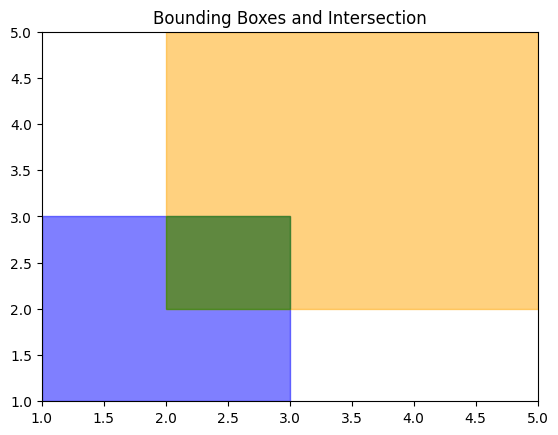

In [8]:
#---------------- vars 

#lower left coordinates as (x1,y1) and upper right coordinates as (a1,b1).

x1 = 1
y1 = 1
a1 = 3 
b1 = 3 

x2 = 2 
y2 = 2
a2=  5
b2 = 5



# find the area for the box1 (x1,y1) (a1,b1)
area1 = (a1-x1)*(b1-y1)
 
# find the area for the box2 (x2,y2) (a2,b2)
area2 = (a2-x2)*(b2-y2)

# Now we need to find the intersection box
# to do that, find the largest (x, y) coordinates 
# for the start of the intersection bounding box and 
# the smallest (x, y) coordinates for the 
# end of the intersection bounding box
xx = max(x1, x2)
yy = max(y1, y2)

aa = min(a1, a2)
bb = min(b1, b2)
 
# So the intersection BBox has the coordinates (xx,yy) (aa,bb)
# compute the width and height of the intersection bounding box
w = max(0, aa - xx)
h = max(0, bb - yy)
 
# find the intersection area
intersection_area = w*h
 
# find the union area of both the boxes
union_area = area1 + area2 - intersection_area
 
# compute the ratio of overlap between the computed
# bounding box and the bounding box in the area list
IoU = intersection_area / union_area



#--- visualization 


# Define the coordinates of the boxes
box1 = {'x': x1, 'y': y1, 'a': a1, 'b': b1}
box2 = {'x': x2, 'y': y2, 'a': a2, 'b': b2}

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the first box
ax.add_patch(plt.Rectangle((box1['x'], box1['y']), box1['a'] - box1['x'], box1['b'] - box1['y'], alpha=0.5, color='blue'))

# Plot the second box
ax.add_patch(plt.Rectangle((box2['x'], box2['y']), box2['a'] - box2['x'], box2['b'] - box2['y'], alpha=0.5, color='orange'))

# Plot the intersection box
ax.add_patch(plt.Rectangle((xx, yy), w, h, alpha=0.5, color='green'))

# Set axis limits based on the bounding boxes
ax.set_xlim(min(x1, x2, a1, a2), max(x1, x2, a1, a2))
ax.set_ylim(min(y1, y2, b1, b2), max(y1, y2, b1, b2))

plt.title('Bounding Boxes and Intersection')
plt.show()

In [9]:
def nms_pytorch(P : torch.tensor ,thresh_iou : float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image 
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """
 
    # we extract coordinates for every 
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]
 
    # we extract the confidence scores as well
    scores = P[:, 4]
 
    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)
     
    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()
 
    # initialise an empty list for 
    # filtered prediction boxes
    keep = []
     
 
    while len(order) > 0:
         
        # extract the index of the 
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]
 
        # push S in filtered predictions list
        keep.append(P[idx])
 
        # remove S from P
        order = order[:-1]
 
        # sanity check
        if len(order) == 0:
            break
         
        # select coordinates of BBoxes according to 
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)
 
        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
 
        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1
         
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
 
        # find the intersection area
        inter = w*h
 
        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order) 
        
        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
        
        # find the IoU of every prediction in P with S
        IoU = inter / union
 
        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
     
    return keep

In [42]:
#---- torch index function 
x = torch.arange(9).view(3,3)
print(x)

index = torch.LongTensor([0,2])
torch.index_select(x,dim=1,index=index)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


tensor([[0, 2],
        [3, 5],
        [6, 8]])

In [10]:
# Let P be the following
P = torch.tensor([
    [1, 1, 3, 3, 0.95],
    [1, 1, 3, 4, 0.93],
    [1, 0.9, 3.6, 3, 0.98],
    [1, 0.9, 3.5, 3, 0.97]
])

In [29]:
max([max(i) for i in P])

tensor(4.)

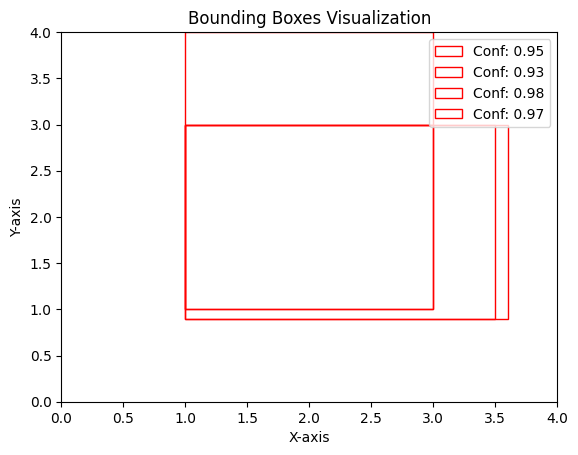

In [35]:
# Visualize
import matplotlib.patches as patches

def vis(data):

    P = data
    # Create a figure and axis
    fig, ax = plt.subplots()


    color_pallete= ['red','black','green','cyan']

    # Plot bounding boxes
    for i,box in enumerate(P):
        x, y, w, h, confidence = box.tolist()
        rect = patches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor='red', facecolor='none', label=f'Conf: {confidence:.2f}')
        ax.add_patch(rect)

    # Set axis limits based on the bounding boxes
    ax.set_xlim(0,max([max(i) for i in P]))
    ax.set_ylim(0,max([max(i) for i in P]))

    # Display legend
    ax.legend()

    # Set labels
    plt.title('Bounding Boxes Visualization')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Show the plot
    plt.show()

#-----
vis(P)

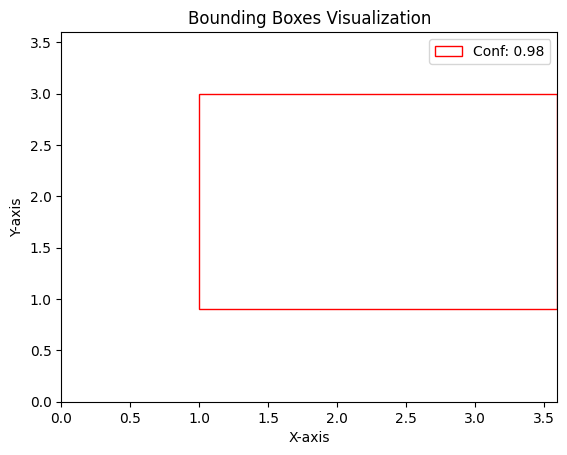

In [36]:
filtered_boxes = nms_pytorch(P,0.5)

#---
vis(filtered_boxes)

# Sample Data Test

## load label

In [22]:
# Open the file in read mode
with open('/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Data/NMS_Test_Data/labels.txt', 'r') as file:
    # Read lines from the file
    lines = file.readlines()

# Initialize an empty list to store the parsed data
data = []

# Iterate over each line and parse the values
for line in lines:
    values = list(map(float, line.split()))
    data.append(values)

# Convert the list of lists to a NumPy array for further processing if needed
import numpy as np
data_array = np.array(data)

# Display the parsed data
print(data_array)

[[3.31860e+02 6.47710e+01 3.96510e+02 1.96329e+02 2.38000e-01]
 [3.33997e+02 6.93360e+01 3.93069e+02 1.97359e+02 8.56000e-01]
 [3.33275e+02 6.43500e+01 3.96262e+02 1.97069e+02 2.45000e-01]
 ...
 [6.00430e+01 3.61655e+02 1.31022e+02 4.89039e+02 5.24000e-01]
 [5.90990e+01 3.61463e+02 1.32899e+02 4.89276e+02 5.88000e-01]
 [2.00185e+02 3.51296e+02 2.61982e+02 4.82739e+02 6.93000e-01]]


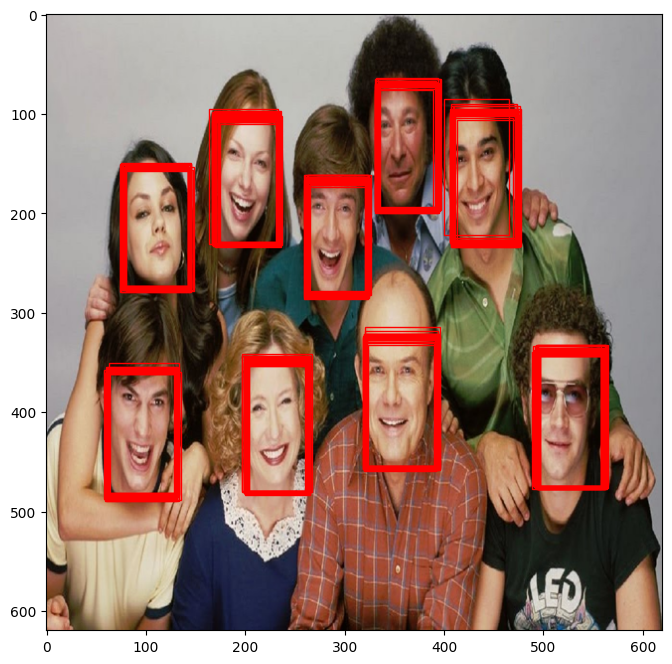

In [15]:
#--- image 
from PIL import Image

img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Data/NMS_Test_Data/sample.jpg"
img = Image.open(img_path)
img = img.resize((620,620))

#--- 
boxes = data_array

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the image
ax.imshow(img)

# Plot bounding boxes
for box in boxes:
    x, y, w, h, _ = box
    rect = patches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [38]:
boxes.shape

torch.Size([309, 5])

/tmp/ipykernel_1334052/463677373.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(boxes)


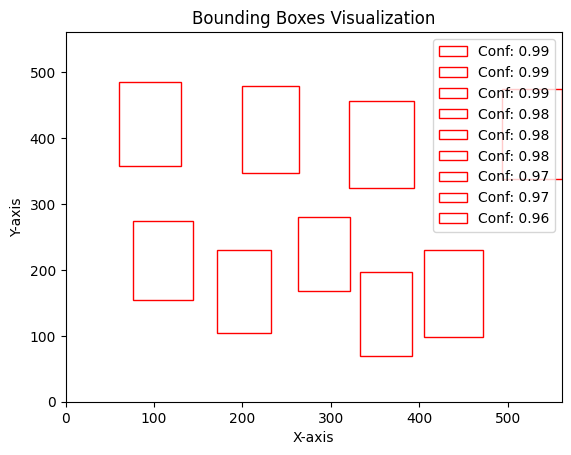

In [37]:

#---
boxes = torch.tensor(boxes)
filtered_boxes = nms_pytorch(boxes,0.5)

#---
vis(filtered_boxes)

In [2]:
# load np 
# result save 
import numpy as np
result = np.load("/mnt/hdd/eric/.tmp_ipy/00.Data/tmp_/roi_trans_multilabel-epoch-40_mergeiou-0.1_scroethr-0.2_0119.npy",allow_pickle=True)

In [12]:
result.shape

(13,)

In [16]:
a = [3.2932393e+03 ,8.1207257e+02, 1.0898882e+02 ,2.3986515e+01 ,1.3563448e+00
,6.0876243e-02]

a.append(9)

In [17]:
a

[3293.2393, 812.07257, 108.98882, 23.986515, 1.3563448, 0.060876243, 9]

In [49]:
new_boxes = []
for idx, box_class in enumerate(result):
    tmp_ = []
    for box in box_class:
        
        box = list(box)
        box.append(idx)
        print(box)
        tmp_.append(box)
    
    new_boxes.append(tmp_)

[3293.2393, 812.0726, 108.98882, 23.986515, 1.3563448, 0.060876243, 0]
[6060.994, 2579.5344, 100.161, 21.68277, -0.9568328, 0.9798448, 1]
[5118.8965, 1023.82776, 61.411236, 13.4730425, -0.64601135, 0.97629035, 1]
[5111.5347, 738.9839, 58.019283, 13.328696, -0.4255327, 0.9609342, 1]
[5516.8667, 185.23587, 52.787445, 11.451462, 0.1630925, 0.9562534, 1]
[5451.3223, 2709.4692, 117.50202, 17.514902, -1.3537304, 0.9520161, 1]
[5424.376, 474.85135, 78.84154, 10.731701, 0.13657963, 0.9386419, 1]
[6636.701, 2670.0352, 100.777245, 19.379366, 0.73552907, 0.9376408, 1]
[5926.9546, 526.979, 62.407436, 11.320342, 0.14597523, 0.9358817, 1]
[5689.69, 751.537, 53.947735, 11.084511, 0.06130588, 0.9238734, 1]
[5681.5723, 1105.5787, 56.875923, 11.777001, -0.17276847, 0.917345, 1]
[6267.6465, 986.26245, 59.51393, 14.829794, 0.7408632, 0.91487783, 1]
[5788.8467, 1369.7386, 94.01754, 18.711931, -0.1808989, 0.90050584, 1]
[5267.2715, 3318.9658, 91.03189, 22.887062, -0.67304677, 0.8664764, 1]
[6553.677, 3354.8

In [60]:
merged_new_boxes = []
for classes in new_boxes:
    merged_new_boxes.extend(classes) 

# assertion 
    
cnt =0 
for classes in new_boxes:
    for box in classes:
        #print(box)
        cnt +=1
print(cnt)

cnt == merged_new_boxes.__len__()

339


True

In [ ]:
# Rotation box 






In [ ]:
def new_nms_pytorch(P : torch.tensor ,thresh_iou : float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image 
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """
 
    # we extract coordinates for every 
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]
    rotation = P[:, 4]

    # calculate rotate box iou 
    

 
    # we extract the confidence scores as well
    scores = P[:, 5]
 
    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)
     
    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()
 
    # initialise an empty list for 
    # filtered prediction boxes
    keep = []
     
 
    while len(order) > 0:
         
        # extract the index of the 
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]
 
        # push S in filtered predictions list
        keep.append(P[idx])
 
        # remove S from P
        order = order[:-1]
 
        # sanity check
        if len(order) == 0:
            break
         
        # select coordinates of BBoxes according to 
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)
 
        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
 
        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1
         
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
 
        # find the intersection area
        inter = w*h
 
        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order) 
        
        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
        
        # find the IoU of every prediction in P with S
        IoU = inter / union
 
        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
     
    return keep

In [ ]:


#-- save
np.save("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Data/tmp/boxes.npy",new_boxes)

In [24]:
for i in result[0][0]:
    print(i)

3293.2393
812.0726
108.98882
23.986515
1.3563448
0.060876243
